# Question Answering

In [ ]:
import transformers
import random
from tqdm.auto import tqdm
from datasets import load_dataset, load_metric, ClassLabel, Sequence
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering, DefaultDataCollator, create_optimizer
import numpy as np
import pandas as pd
import tensorflow as tf
import evaluation_custom as ev
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import OrderedDict
import evaluation_custom as ev
import json
import string
import re

Default dataset is the SQuAD dataset which is contained in training_set.json
and you change it accordingly

We can use the model of our choice with *ind* variable

In [ ]:
duorc = False  # Set to False if you want to test only on SQuAD
train = False  # Set to False if you do not want to train the model
ind = 2  # Change the index from 0 to 2 to test different transformers
model_checkpoint_list = ["distilbert-base-uncased", "distilroberta-base", 'albert-base-v2']
model_checkpoint = model_checkpoint_list[ind]

In [ ]:
import json
from datasets import load_dataset

# Load the SQuAD dataset
dataset_squad = load_dataset('squad', split='train')  # You can use 'train', 'validation', or 'test' splits
df_squad = dataset_squad.to_pandas()

# Drop any rows with missing answers (if applicable)
df_squad = df_squad.dropna(subset=['answers'])

# Initialize lists to store answer start positions and answers
start_char = []
to_remove = []

# Iterate over the rows to find start positions of answers
for i, row in df_squad.iterrows():
    try:
        # Find the start position of the answer in the context
        start_char.append(row['context'].index(row['answers']['text'][0]))
    except ValueError:  # Handle case where the answer is not found in context
        to_remove.append(i)

# Drop rows that could not be processed
df_squad = df_squad.drop(index=to_remove)

# Reset index after removing rows
df_squad = df_squad.reset_index(drop=True)

# Create answers column as a list of dictionaries
df_squad['answers'] = [
    {'answer_start': [start], 'text': [ans]}
    for start, ans in zip(start_char, df_squad['answers'].apply(lambda x: x['text'][0]))
]

# Rename columns for consistency
df_squad = df_squad.rename(columns={'title': 'title', 'question': 'question', 'context': 'context', 'answers': 'answers'})

# Write processed data to a JSON file
with open("squad.json", 'w') as f:  # Use 'w' to overwrite the file each time
    for i in range(df_squad.shape[0]):
        entry = {
            "id": df_squad['id'][i],
            "title": df_squad['title'][i],
            "context": df_squad['context'][i],
            "question": df_squad['question'][i],
            "answers": df_squad['answers'][i],
        }
        f.write(json.dumps(entry) + "\n")


In [ ]:
import json
import pandas as pd
from datasets import load_dataset

# Load dataset if duorc flag is True
if duorc:
    dataset_duorc = load_dataset('duorc', 'SelfRC', split='test')
    df_duorc = dataset_duorc.to_pandas()

    # Drop unnecessary columns and rows
    df_duorc = df_duorc.drop(columns=['plot_id', 'no_answer'], errors='ignore')
    df_duorc = df_duorc[df_duorc['no_answer'] != True]

    # Initialize lists for answer start positions and answers
    start_char = []
    to_remove = []

    # Iterate over the rows to find start positions of answers
    for i, row in df_duorc.iterrows():
        try:
            start_char.append(row['plot'].index(row['answers'][0]))
        except ValueError:  # Handle case where the answer is not found in plot
            to_remove.append(i)

    # Drop rows that could not be processed
    df_duorc = df_duorc.drop(index=to_remove)

    # Reset index after removing rows
    df_duorc = df_duorc.reset_index(drop=True)

    # Create answers column as a list of dictionaries
    df_duorc['answers'] = [
        {'answer_start': [start], 'text': [ans]}
        for start, ans in zip(start_char, df_duorc['answers'].apply(lambda x: x[0]))
    ]

    # Rename columns for consistency
    df_duorc = df_duorc.rename(columns={'plot': 'context', 'question_id': 'id'})

    # Write processed data to a JSON file
    with open("duorc.json", 'w') as f:  # Use 'w' to overwrite the file each time
        for i in range(df_duorc.shape[0]):
            entry = {
                "id": df_duorc['id'][i],
                "title": df_duorc['title'][i],
                "context": df_duorc['context'][i],
                "question": df_duorc['question'][i],
                "answers": df_duorc['answers'][i],
            }
            f.write(json.dumps(entry) + "\n")


In [ ]:
import json
from datasets import load_dataset

# Load dataset from files (train, validation, and test)
dataset = load_dataset('json', data_files={'train': train_filename, 'validation': val_filename, 'test': test_filename})

# Initialize the ground truth dictionary
ground_tr_dict = {}

# If the DUORC flag is True
if duorc:
    # Extract relevant information from the DUORC dataset
    ground_truth = []
    ids = dataset['test']['id']
    answ = dataset['test']['answers']

    # Iterate through the test set to extract ground truth data
    for i in range(0, len(dataset['test'])):
        ground_truth.append([ids[i], answ[i]['text'][0]])

    # Save the ground truth data into a JSON file
    with open('ground_truth.json', 'w') as json_file:
        json.dump(ground_truth, json_file)

    # Prepare the final ground truth dictionary
    ground_tr_dict['data'] = df_duorc

else:
    # Prepare ground truth for other datasets (e.g., SQuAD)
    ground_tr_dict['data'] = dataset_base['data'][train_split:]
    ground_tr_dict['version'] = dataset_base['version'][train_split:]

    # Write the ground truth for the other dataset into a JSON file
    with open('ground_truth.json', 'w') as json_file:
        json.dump(ground_tr_dict, json_file)


In [ ]:
#showing our dataset
dataset['train'][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

Now we show the distributions of the lengths of answer, text and question (of training and test set) in order to study the dataframe and the respective results.

In [ ]:
def len_answer(dataset,type):
  len_answers = []
  for i in range(0,len(dataset[type])):
    for j in range(0,len(dataset[type][i]['answers']['text'])):
      len_answers.append(len(dataset[type][i]['answers']['text'][j].split()))
  return len_answers

In [ ]:
def len_maker(dataset,type,feature):
  len_ = []
  for i in range(0,len(dataset[type])):
      len_.append(len(dataset[type][i][feature].split()))
  return len_

In [ ]:
# len_answers = len_answer(dataset,"train")
# keys, counts = np.unique(len_answers, return_counts=True)

# plt.figure(figsize=(8,5))
# plt.bar(keys, counts)
# plt.title('Distribution of Answers length on Training Set', fontsize=16)
# plt.ylabel('Number of answer')
# plt.xlabel('Answer Length in words')
# plt.show()

In [ ]:
# len_answers_val = len_answer(dataset,"test")
# keys, counts = np.unique(len_answers_val, return_counts=True)

# plt.figure(figsize=(8,5))
# plt.bar(keys, counts)
# plt.title('Distribution of Answers length on Test Set', fontsize=16)
# plt.ylabel('Number of answers')
# plt.xlabel('Answer Length in words')
# plt.show()

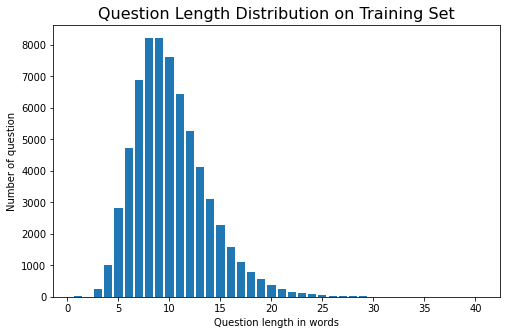

In [ ]:
len_question = len_maker(dataset,"train", "question")
keys, counts = np.unique(len_question, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(keys, counts)
plt.title('Question Length Distribution on Training Set', fontsize=16)
plt.ylabel('Number of question')
plt.xlabel('Question length in words')
plt.show()

In [ ]:
len_question_val = len_maker(dataset,"validation", "question")
keys, counts = np.unique(len_question_val, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(keys, counts)
plt.title('Question Length Distribution on Test Set', fontsize=16)
plt.ylabel('Number of question')
plt.xlabel('Question length in words')
plt.show()

In [ ]:
batch_size = 2 # suggested by the official paper at 16-32, but due to technical limitation we are forced to set it at 2 and still works well
learning_rate = 2e-5 # other admissible by suggestion are 5e-5 and 3e-5
num_train_epochs = 3  #Usually for all the 3 models the best number of epochs before starting overfitting
weight_decay = 0.01
max_length = 384  # The maximum length of a feature (question and context)
doc_stride = 128  # The authorized overlap between two part of the context when splitting it is needed.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def tokenize_dataset(dataset):
    #Since the roberta-like tokenizer have problems to deal with long sequences of spaces before and after the
    #text, it is needed some more data cleaning
    if model_checkpoint == "roberta-base" or "distilroberta-base":
        dataset["question"] = [q.lstrip() for q in dataset["question"]]
    # Tokenize our questions with truncation and padding, but keep the overflows using a stride. This results
    # in one question possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.

    tokenized_dataset = tokenizer(  dataset["question"], dataset["context"],
                                    truncation="only_second",
                                    max_length=max_length,
                                    stride=doc_stride,
                                    return_overflowing_tokens=True,
                                    return_offsets_mapping=True,
                                    padding="max_length",
    )


    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding question. This key gives us just that.

    overflowing_tokens = tokenized_dataset.pop("overflow_to_sample_mapping") #with pop we remove the selected column from the dataset and we store it in sample mapping,
                                                                         #basically this is a vector with enumerations from 0 to the lenght of the vector
                                                                         #created by return_overflowing_tokens in the tokenizer object

    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.

    offset_mapping = tokenized_dataset.pop("offset_mapping") # created by return_offsets_mapping in the tokenizer object


    # Now we have to label the questions

    tokenized_dataset["start_positions"] , tokenized_dataset["end_positions"] = list(),list()


    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers (the answer is in another feature given by an example with a long context), with the index of the CLS token.
        input_ids = tokenized_dataset["input_ids"][i] # The list of numerical token associated to the words of the i-th context

        #The first token of every sequence is always a special classification token ([CLS]), in this case is tokenizer.cls_token_id = 101. The final hidden state corresponding to this token is used
        # as the aggregate sequence representation for classification tasks. The last token of every sequence is instead 102.
        cls_index = input_ids.index(tokenizer.cls_token_id) #usually 0

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        # If None, it's a separator (i.e. CLS), 0 is the question tag, 1 is the answer one
        sequence_ids = tokenized_dataset.sequence_ids(i)
        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = overflowing_tokens[i]
        answers = dataset["answers"][sample_index]


        # Start/end character index of the answer in the text.

        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        # Start token index of the current span in the text.
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        # End token index of the current span in the text.
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
        if(offsets[token_start_index][0] > start_char
                or offsets[token_end_index][1] < end_char):

            tokenized_dataset["start_positions"].append(cls_index)
            tokenized_dataset["end_positions"].append(cls_index)
        else:
            # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
            # Note: we could go after the last offset if we are in the edge case such that the answer is the last word.
            while (
                token_start_index < len(offsets)
                and offsets[token_start_index][0] <= start_char
            ):
                token_start_index += 1
            tokenized_dataset["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_dataset["end_positions"].append(token_end_index + 1)

    return tokenized_dataset


tokenized_datasets = dataset.map(tokenize_dataset, batched=True, remove_columns=dataset["train"].column_names)

Now we need a data collator that simply collates batches of our processed examples together.

Then we can use this data collator to turn our data into a `tf.data.Dataset`, ready for training.

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

train_set = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,)

validation_set = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "start_positions", "end_positions"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,)

In [ ]:
total_train_steps = (len(tokenized_datasets["train"]) // batch_size) * num_train_epochs
optimizer, schedule = create_optimizer(init_lr=learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps)

model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
model.compile(optimizer=optimizer)

path = './fine_tuned_' + model_checkpoint +  '/'

if train == True:
    model.fit(train_set, epochs=num_train_epochs, validation_data=validation_set)
    model.save_pretrained(path)
else:
    model.load_weights(path + 'tf_model.h5')

In [ ]:
def prepare_test_features(dataset):
    #Since the roberta-like tokenizer have problems to deal with long sequences of spaces before and after the
    #text, it is needed some more data cleaning
    if model_checkpoint == "roberta-base" or "distilroberta-base":
        dataset["question"] = [q.lstrip() for q in dataset["question"]]
    # Tokenize our questions with truncation and padding, but keep the overflows using a stride. This results
    # in one question possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_dataset = tokenizer(
        dataset["question"],
        dataset["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    overflowing_tokens = tokenized_dataset.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_dataset["example_id"] = []

    for i in range(len(tokenized_dataset["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_dataset.sequence_ids(i)
        context_index = 1

        # One example can give several spans, this is the index of the example containing this span of text.
        token_index = overflowing_tokens[i]
        tokenized_dataset["example_id"].append(dataset["id"][token_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_dataset["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_dataset["offset_mapping"][i])]

    return tokenized_dataset

Now we can finally prepare the test dataset and

In [ ]:
test_features = dataset["test"].map(
    prepare_test_features,
    batched=True,
    remove_columns=dataset["test"].column_names)

test_dataset = test_features.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator)

raw_predictions = model.predict(test_dataset)


In [ ]:
def postprocess_qa_predictions(
    examples,
    features,
    all_start_logits,
    all_end_logits,
    n_best_size=20,
    max_answer_length=30,
):
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)

    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    print(
        f"Post-processing {len(examples)} example predictions split into {len(features)} features."
    )

    # Now we need to
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(
                tokenizer.cls_token_id
            )
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            min_null_score = feature_null_score

            # Go through all possibilities for the n_best_size greater start and end logits.
            start_indexes = np.argsort(start_logits)[ -1 : -n_best_size - 1 : -1 ].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    try:

                        start_char = offset_mapping[start_index][0]
                        end_char = offset_mapping[end_index][1]
                        valid_answers.append(
                            {
                                "score": start_logits[start_index] + end_logits[end_index],
                                "text": context[start_char:end_char],
                            }
                        )

                    except IndexError:
                        start_char = 0
                        end_char = 0
                        valid_answers.append(
                            {
                                "score": 0,
                                "text": context[start_char:end_char],
                            }
                        )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[
                0
            ]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        predictions[example["id"]] = best_answer["text"]


    return predictions

final_predictions = postprocess_qa_predictions(
    dataset["test"],
    test_features,
    raw_predictions["start_logits"],
    raw_predictions["end_logits"])

In [ ]:
#CODE TO EVALUATE THE QUALITY OF THE MODEL'S ANSWERS
with open('predictions.json', 'w') as json_file:
    json.dump(final_predictions, json_file)

if duorc == True:
  exact_scores, f1_scores = ev.get_raw_scores_duorc(ground_truth, final_predictions)
  print(ev.make_eval_dict(exact_scores, f1_scores))
else:
  !python3 evaluate.py ground_truth.json predictions.json

{
  "exact": 64.24044734389562,
  "f1": 79.99211122229185,
  "total": 21460,
  "HasAns_exact": 64.24044734389562,
  "HasAns_f1": 79.99211122229185,
  "HasAns_total": 21460
}
